# PyDeepGP tutorial

In [1]:
import numpy as np
import GPy
from pylab import *
%matplotlib inline
import os
from sys import path
np.random.seed(42)

In [2]:
# Add parent directory to path if deepgp is not there already
pwd = os.getcwd()
base_path = pwd[0:pwd.rfind(os.sep)]
path.insert(0,base_path)

In [3]:
import deepgp

In [4]:
# Utility to load sample data. It can be installed with pip. Otherwise just load some other data.
import pods

## Unsupervised learning (oil data)

In [5]:
# Load data
data = pods.datasets.oil_100()
Y = data['X']
labels =  data['Y'].argmax(axis=1)

# Number of latent dimensions per layer
Q1, Q2 = 5, 4

# Type of kernel per layer
kern1 = GPy.kern.RBF(Q1,ARD=True) + GPy.kern.Bias(Q1)
kern2 = GPy.kern.RBF(Q2,ARD=True) + GPy.kern.Bias(Q2)

# Number of inducing points per layer (can be set to different if given as list).
num_inducing = 40

# Whether to use back-constraint for variational posterior
back_constraint = False

# Dimensions of the MLP back-constraint if set to true
encoder_dims=[[300],[150]]

In [7]:
m = deepgp.DeepGP([Y.shape[1],Q1,Q2],
                  Y,kernels=[kern1,kern2], 
                  num_inducing=num_inducing, 
                  back_constraint=back_constraint, 
                  encoder_dims = encoder_dims)

In [8]:
# Make sure initial noise variance gives a reasonable signal to noise ratio
for i in range(len(m.layers)):
    output_var = m.layers[i].Y.var() if i==0 else m.layers[i].Y.mean.var()
    m.layers[i].Gaussian_noise.variance = output_var*0.01

In [9]:
m.optimize(max_iters=5000, messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s12  0001   7.755559e+04   8.005322e+09 
    01s12  0037   1.108158e+02   7.873395e+02 
    03s13  0121  -5.507231e+01   1.949809e+02 
    11s21  0447  -1.728118e+02   2.852418e+01 
    35s51  1340  -2.465651e+02   1.361611e+02 
    49s69  1848  -2.566525e+02   1.575437e+01 
 02m26s44  5002  -2.615853e+02   1.870644e+00 
Runtime:  02m26s44
Optimization status: Maximum number of f evaluations reached



 /Users/neil/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


 /Users/neil/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


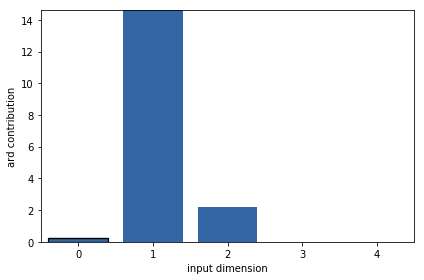

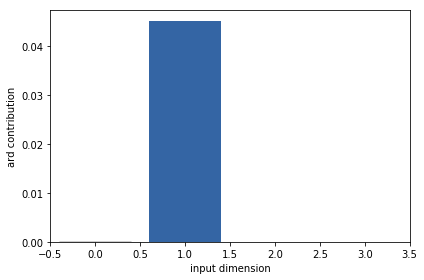

In [10]:
# Plot ARD scales per layer
m.obslayer.kern.plot_ARD()
m.layer_1.kern.plot_ARD()

Text(0.5,1,'Layer 1')

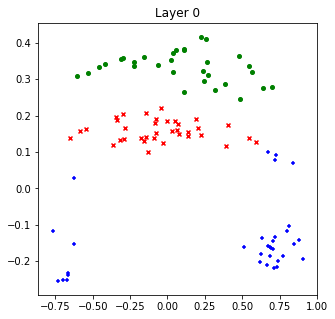

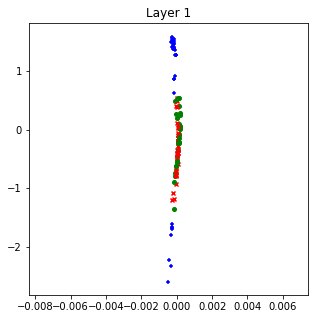

In [11]:
# From the plots above, we see which ones are the dominant dimensions for each layer. 
# So we use these dimensions in the visualization of the latent space below.
plt.figure(figsize=(5,5))
deepgp.util.visualize_DGP(m, labels, layer=0, dims=[1,2]); plt.title('Layer 0')
plt.figure(figsize=(5,5))
deepgp.util.visualize_DGP(m, labels, layer=1, dims=[0,1]); plt.title('Layer 1')

## Supervised learning

In [12]:
# Load some mocap data.
data = pods.datasets.cmu_mocap_35_walk_jog()

Ntr = 100
Nts = 500

# All data represented in Y_all, which is the angles of the movement of the subject
Y_all = data['Y']
perm = np.random.permutation(Ntr+Nts)
index_training = np.sort(perm[0:Ntr])
index_test     = np.sort(perm[Ntr:Ntr+Nts])

Y_all_tr = Y_all[index_training,:]
Y_all_ts = Y_all[index_test,    :]


# Some of the features (body joints) to be used as inputs, and some as outputs
X_tr = Y_all_tr[:,0:55].copy()
Y_tr = Y_all_tr[:, 55:].copy()

X_ts = Y_all_ts[:,0:55].copy()
Y_ts = Y_all_ts[:, 55:].copy()

# TODO: You might need to normalize the input and/or output data.

In [13]:
# Number of latent dimensions (single hidden layer, since the top layer is observed)
Q = 5

# Define what kernels to use per layer
kern1 = GPy.kern.RBF(Q,ARD=True) + GPy.kern.Bias(Q)
kern2 = GPy.kern.RBF(Q,ARD=False) + GPy.kern.Bias(X_tr.shape[1])

# Number of inducing points to use
num_inducing = 40

# Whether to use back-constraint for variational posterior
back_constraint = False

# Dimensions of the MLP back-constraint if set to true
encoder_dims=[[300],[150]]

In [14]:
m = deepgp.DeepGP([Y_tr.shape[1],Q,X_tr.shape[1]],
                  Y_tr, X_tr=X_tr,kernels=[kern1, kern2], 
                  num_inducing=num_inducing, back_constraint=back_constraint)

In [15]:
# Make sure initial noise variance gives a reasonable signal to noise ratio.
# Fix to that value for a few iterations to avoid early local minima
for i in range(len(m.layers)):
    output_var = m.layers[i].Y.var() if i==0 else m.layers[i].Y.mean.var()
    m.layers[i].Gaussian_noise.variance = output_var*0.01
    m.layers[i].Gaussian_noise.variance.fix()

In [16]:
display(m)

deepgp.,value,constraints,priors
obslayer.inducing inputs,"(40, 5)",,
obslayer.sum.rbf.variance,1.0,+ve,
obslayer.sum.rbf.lengthscale,"(5,)",+ve,
obslayer.sum.bias.variance,1.0,+ve,
obslayer.Gaussian_noise.variance,2.13179847772,+ve fixed,
obslayer.Kuu_var,"(40,)",+ve,
obslayer.latent space.mean,"(100, 5)",,
obslayer.latent space.variance,"(100, 5)",+ve,
layer_1.inducing inputs,"(40, 55)",,
layer_1.sum.rbf.variance,1.0,+ve,


In [17]:
m.optimize(max_iters=800, messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s18  001   2.772929e+04   2.660103e+08 
    01s20  040   5.172149e+03   2.273552e+05 
    05s22  196   1.541046e+03   1.879665e+02 
    06s24  236   1.530905e+03   7.159914e+02 
    19s41  743   1.429718e+03   1.042016e+02 
    20s97  802   1.425838e+03   7.004558e+01 
Runtime:     20s97
Optimization status: Maximum number of f evaluations reached



In [18]:
# Unfix noise variance now that we have initialized the model
for i in range(len(m.layers)):
    m.layers[i].Gaussian_noise.variance.unfix()

In [19]:
m.optimize(max_iters=1500, messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s14  0001   1.425838e+03   3.782786e+03 
    03s18  0101   1.307856e+03   8.537983e+02 
    10s24  0339   1.293169e+03   2.541807e+01 
    32s56  1027   1.292130e+03   1.878501e+01 
    48s12  1502   1.291413e+03   1.317024e+01 
Runtime:     48s12
Optimization status: Maximum number of f evaluations reached



### Compare with GP

In [20]:
m_GP = GPy.models.SparseGPRegression(X=X_tr, Y=Y_tr, kernel=GPy.kern.RBF(X_tr.shape[1])+GPy.kern.Bias(X_tr.shape[1]), num_inducing=num_inducing)

In [21]:
m_GP.Gaussian_noise.variance = m_GP.Y.var()*0.01
m_GP.Gaussian_noise.variance.fix()
m_GP.optimize(max_iters=100, messages=True)
m_GP.Gaussian_noise.variance.unfix()
m_GP.optimize(max_iters=400, messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s19  006   2.463751e+03   4.986610e+02 
    00s33  027   2.339956e+03   5.774437e-11 
Runtime:     00s33
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s07  004   1.855557e+03   2.678079e+03 
    00s18  011   1.778417e+03   5.465010e-02 
    00s32  029   1.778190e+03   1.885596e-09 
Runtime:     00s32
Optimization status: Converged



In [22]:
def rmse(predictions, targets):
    return np.sqrt(((predictions.flatten() - targets.flatten()) ** 2).mean())


In [23]:
Y_pred = m.predict(X_ts)[0]
Y_pred_s = m.predict_withSamples(X_ts, nSamples=500)[0]
Y_pred_GP = m_GP.predict(X_ts)[0]

print('# RMSE DGP               : ' + str(rmse(Y_pred, Y_ts)))
print('# RMSE DGP (with samples): ' + str(rmse(Y_pred_s, Y_ts)))
print('# RMSE GP                : ' + str(rmse(Y_pred_GP, Y_ts)))

# RMSE DGP               : 3.03000726496
# RMSE DGP (with samples): 3.03436330576
# RMSE GP                : 3.02347121967
